In [1]:
import pandas as pd
from utils.text import plot_wordclouds
import seaborn as sns

In [2]:
binary=False

# Carregando dados de análise

In [3]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [5]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [6]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


In [7]:
# Para focar a análise em apenas duas classes: positivo e negativo
if binary:
    data_df = data_df[data_df["label"] != "neutro"]

# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: conversão para lower-case, remoção de stop-words, remoção de hashtags e lemmatização.

In [8]:
import spacy
nlp = spacy.load("pt_core_news_md")

In [9]:
from typing import Iterable

def apply_preprocessing_pipeline(text: str) -> Iterable[str]:

    tokens = nlp(text)
    final_tokens = []

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remoção de stop-words
        if token.is_punct: continue             # remoção de pontuação
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"
        if "@" in lemma: continue               # remoção simples de hashtags

        final_tokens.append(lemma.lower())
    
    return final_tokens

# Conversão dos textos para representações esparsas

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
params = {
    "max_features": 10000,                      # tamanho máximo de vocabulário
    "ngram_range": (1, 3),                      # ngrams 
    "tokenizer": apply_preprocessing_pipeline   # pipeline de pre processamento pelo spacy
}

In [12]:
vectorizer = CountVectorizer(**params)
# vectorizer = TfidfVectorizer(**params)

In [13]:
text_vectors = vectorizer.fit_transform(data_df["text"].values)

In [14]:
text_vectors.shape

(2463, 10000)

In [15]:
vectorizer.get_feature_names()[:10]

["'s",
 '+',
 '1',
 '1 globo',
 '1 globo esporte',
 '=',
 '`',
 'aaaaa',
 'aaaaaa',
 'aaaaaaa']

# Agrupamento usando K-means

In [16]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [17]:
# Quantidades de clusters para avaliar
n_clusters = list(range(2,11))
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [18]:
fitted_models = []
for k in tqdm(n_clusters):
    
    kmeans = KMeans(n_clusters=k, n_init=100, init='random', max_iter=500)
    kmeans.fit(text_vectors)

    fitted_models.append(kmeans)

100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


# Avaliando silhueta dos agrupamentos gerados

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster.silhouette import silhouette_visualizer
import numpy as np
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

In [21]:
sns.set(rc={'figure.figsize':(15,6)})

In [22]:
silhouettes = [silhouette_score(text_vectors, kmeans.labels_) for kmeans in fitted_models]
inertias = [kmeans.inertia_ for kmeans in fitted_models]

Text(0.5, 0, 'Number of clusters')

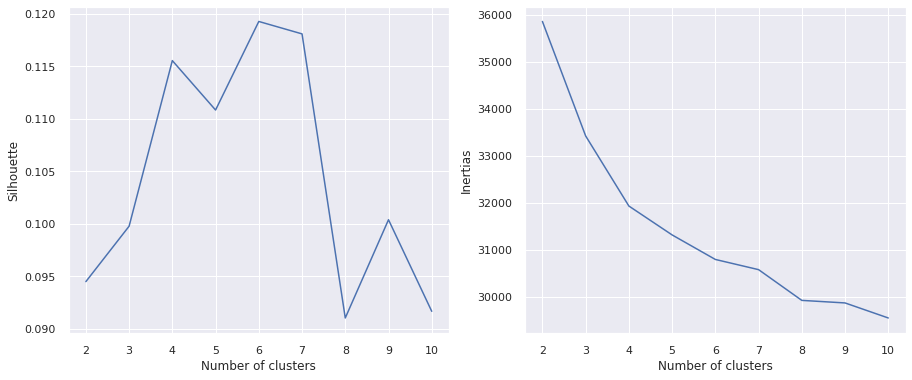

In [23]:
fig, axes = plt.subplots(1,2)

ax = sns.lineplot(x=n_clusters, y=silhouettes, ax=axes[0])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Number of clusters")

ax = sns.lineplot(x=n_clusters, y=inertias, ax=axes[1])
ax.set_ylabel("Inertias")
ax.set_xlabel("Number of clusters")

In [24]:
# Escolhendo o modelo de maior silhueta mpedia para análise
kmeans = fitted_models[np.argmax(silhouettes)]

In [25]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)
data_df["cluster"] = kmeans.labels_

In [26]:
mean_silh = data_df["silhouette"].mean()

In [27]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 30791.299940865836
- Mean silhouette: 0.1192524968896448


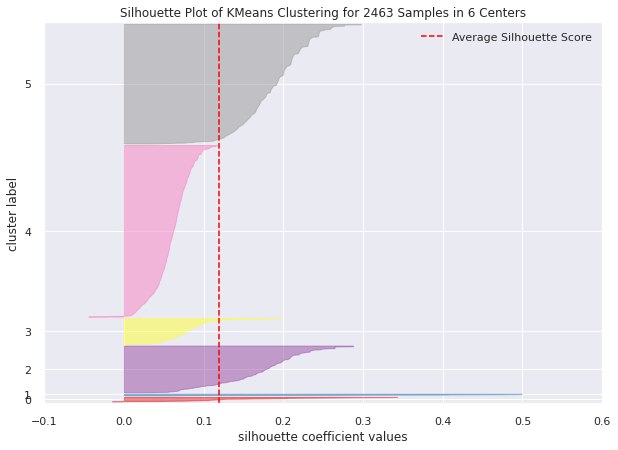

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f97d1ebdfd0>,
                     estimator=KMeans(init='random', max_iter=500, n_clusters=6,
                                      n_init=100))

In [28]:
sns.set(rc={'figure.figsize':(10,7)})
silhouette_visualizer(
    kmeans,
    X=text_vectors.todense(),
    y=data_df["label"].values,
    is_fitted=True
)

# Comparação entre clusters

Comparando pares de clusters, com relação as classes (positivo, neutro ou negativo) e palavras frequentes.

In [29]:
cluster_pair = (0, 1)

In [30]:
c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

# Distribuição de classes por cluster

In [31]:
order = ["positivo", "negativo"] if binary else \
        ["positivo", "neutro", "negativo"]

Text(0.5, 0, 'Cluster 1')

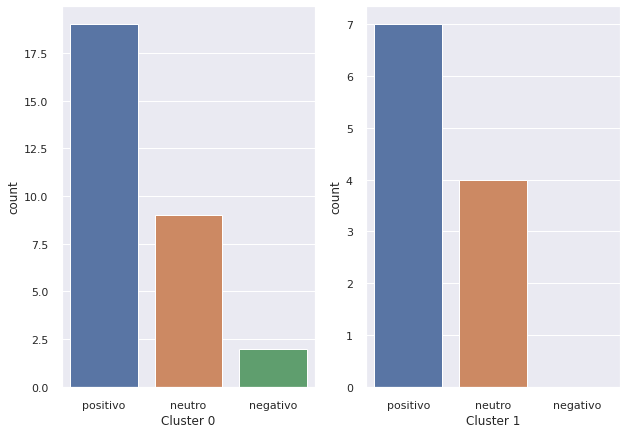

In [32]:
fig, axes = plt.subplots(1,2)

sns.countplot(data=c0_df, x="label", ax=axes[0], order=order)
axes[0].set_xlabel(f"Cluster {cluster_pair[0]}")
sns.countplot(data=c1_df, x="label", ax=axes[1], order=order)
axes[1].set_xlabel(f"Cluster {cluster_pair[1]}")

## Wordclouds por cluster

Gerando nuvens de palavras para cluster do par em análise.

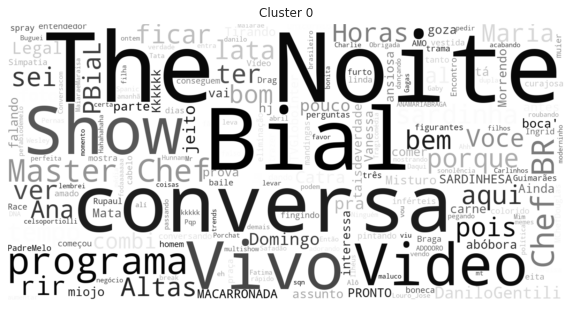

In [33]:
plot_wordclouds(
    text=" ".join(c0_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[0]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

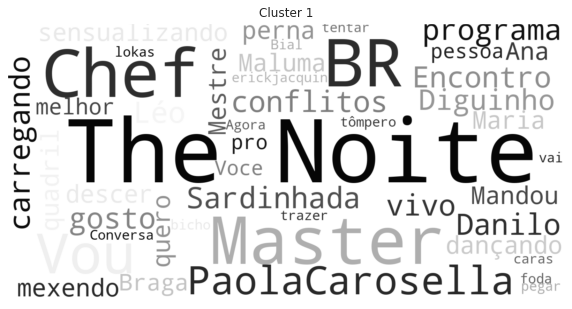

In [34]:
plot_wordclouds(
    text=" ".join(c1_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[1]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

# Visualizando exemplos de maior silhueta por cluster

In [35]:
cluster = 1

In [36]:
c_df = data_df[data_df["cluster"] == cluster]

In [37]:
pd.set_option('max_colwidth', None)
c_df.sort_values(by="silhouette", ascending=False).head(10)

,label,text,silhouette,cluster
5028,positivo,O Léo carregando o Danilo 😂😂😂😂😂😂😂😂😂😂 The Noite,0.498949,1
2227,neutro,"@PaolaCarosella: ""Agora que o bicho vai pegar!"" 😂😂😂😂😂😂😂😂😂😂 Master Chef BR",0.497413,1
1322,positivo,Esses caras do The Noite são foda 😂😂😂😂😂😂😂😂😂😂😂😂,0.495384,1
8607,neutro,"@PaolaCarosella pro @erickjacquin: ""Eu vou tentar trazer o ""tômpero""""! 😂😂😂😂😂😂😂😂😂😂 Master Chef BR",0.469703,1
897,positivo,O Diguinho sensualizando com a perna 😂😂😂😂😂😂😂😂😂 The Noite Mestre Mandou,0.409417,1
9420,positivo,"""Eu quero descer!!!"" 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 The Noite",0.403351,1
9427,positivo,😂😂😂😂😂😂😂😂 gosto quando o programa é ao vivo e tem conflitos!!! Encontro,0.298366,1
4243,positivo,"Ana Maria Braga, melhor pessoa 😂😂😂😂😂😂😂😂 Mais Voce",0.260548,1
700,neutro,Sardinhada 😂😂😂😂😂😂😂 Master Chef BR,0.096458,1
1541,positivo,"""Vou dançando mexendo o quadril"" 😂😂😂😂😂😂😂 The Noite Maluma No The Noite",0.070451,1
